In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from joblib import parallel_backend

test_file = '/app/raw/Flights_2018_1.csv'

df = pd.read_csv(test_file, nrows=10000)
# for col in df:
#     print(col)

In [75]:
def analyze_model(model, X_test, X_train, y_test, y_train):
    # TODO score vs score_samples
    test_accuracy = model.score(X_test, y_test)
    train_accuracy = model.score(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    prf = precision_recall_fscore_support(y_test, y_pred, average='binary') # TODO different average values: micro macro binary weighted samples

    print(f"Test accuracy: {test_accuracy}")
    print(f"Train accuracy: {train_accuracy}")
    print(f"Precision: {prf[0]}")
    print(f"Recall: {prf[1]}")
    print(f"F-Beta Score: {prf[2]}")
    print(f"F1 Score: {f1}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

In [76]:

# df[(df['ArrDel15'] != math.isnan)]
df = df[["DayofMonth","Month","Year", "Distance","DepDelay", "ArrDel15"]].dropna()# get rid of nan
print(df.ArrDel15.unique()) # find unique values

X = df[["DayofMonth","Month","Year", "Distance", "DepDelay"]]
y = df[["ArrDel15"]]
y = y.ArrDel15.ravel() # flatten
print(y.shape)

# split into train and 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=150) # TODO how to choose random state

[0. 1.]
(9480,)


In [77]:
# Logistic Regression model creation
log_reg = LogisticRegression()

param_grid = [
  {'solver':['liblinear'],'C':[.001, .01, .5, .1, 1, 5, 10], 'penalty':['l1','l2']},
  {'solver':['saga'],'C':[.001, .01, .5, .1, 1, 5, 10], 'penalty':['l2','elasticnet']} # l1 gives erros here
]

# TODO n_jobs = 5 is ideal for my computer, results may vary
# TODO choose best scoring function f1, f1_macro, etc.
search = GridSearchCV(log_reg, param_grid, scoring='f1', cv=5, verbose=0, n_jobs=-1) 
# TODO how to choose cv
# TODO choose verbosity
# TODO use scoring param?

logreg_model = search.fit(X_train, y_train)


/mamba/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Grid search found best solver: liblinear
Grid search found best penalty: l1
Grid search found best hyperparameter C: 0.01
Test accuracy: 0.7758007117437723
Train accuracy: 0.8050089445438281
Precision: 0.8755020080321285
Recall: 0.6964856230031949
F-Beta Score: 0.7758007117437723
F1 Score: 0.7758007117437723


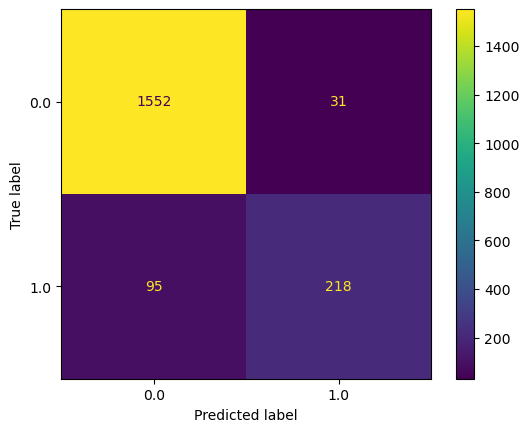

In [78]:
# Logistic Regression Evaluation
print('Grid search found best solver:', logreg_model.best_estimator_.get_params()['solver'])
print('Grid search found best penalty:', logreg_model.best_estimator_.get_params()['penalty'])
print('Grid search found best hyperparameter C:', logreg_model.best_estimator_.get_params()['C'])

# TODO confirm this is actually printing for best model from gridsearch
analyze_model(logreg_model, X_test, X_train, y_test, y_train)


In [79]:
# SVM Model Creation
# NOTE THIS TAKES A FEW MIN TO RUN for n=1000

# reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# parallelize


# create a pipeline to run standardscaler and then the svm
svm = Pipeline(steps=[("scaler", StandardScaler()), ("svm",SVC())]) # standard scaler makes a huge difference of over 10%
# TODO choose metric to measure because accuracy isn't good


# TODO is precomputed kernel type useful?
param_grid = [
  {'svm__gamma':['scale', 'auto'],'svm__C':[.1, .5, 1, 5, 10], "svm__kernel":['linear', 'rbf']},
  {'svm__gamma':['scale', 'auto'], 'svm__C':[.1, .5, 1, 5, 10], 'svm__coef0':[0.0, .01, 1], "svm__kernel":['poly', 'sigmoid']}
]
# adding more values to gamma makes things super slow

search = GridSearchCV(svm, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1) # TODO how to choose cv

svm_model = search.fit(X_train, y_train)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END svm__C=0.5, svm__coef0=0.01, svm__gamma=scale, svm__kernel=poly;, score=0.737 total time=   0.1s
[CV 2/5] END svm__C=0.5, svm__coef0=0.01, svm__gamma=scale, svm__kernel=poly;, score=0.718 total time=   0.1s
[CV 3/5] END svm__C=0.5, svm__coef0=0.01, svm__gamma=auto, svm__kernel=poly;, score=0.757 total time=   0.1s
[CV 4/5] END svm__C=0.5, svm__coef0=0.01, svm__gamma=auto, svm__kernel=poly;, score=0.467 total time=   0.1s
[CV 3/5] END svm__C=0.5, svm__coef0=1, svm__gamma=scale, svm__kernel=poly;, score=0.769 total time=   0.1s
[CV 4/5] END svm__C=0.5, svm__coef0=1, svm__gamma=scale, svm__kernel=poly;, score=0.703 total time=   0.1s
[CV 2/5] END svm__C=0.5, svm__coef0=1, svm__gamma=scale, svm__kernel=sigmoid;, score=0.408 total time=   0.1s
[CV 3/5] END svm__C=0.5, svm__coef0=1, svm__gamma=scale, svm__kernel=sigmoid;, score=0.596 total time=   0.1s
[CV 3/5] END svm__C=1, svm__coef0=0.0, svm__gamma=scale, svm__kern

Grid search found best gamma: scale
Grid search found best penalty: linear
Grid search found best hyperparameter C: 5
The following is only important if using poly or sigmoid kernel:
Grid search found best coef0: 0.0
Test accuracy: 0.7747747747747749
Train accuracy: 0.8027210884353742
Precision: 0.8884297520661157
Recall: 0.6869009584664537
F-Beta Score: 0.7747747747747749
F1 Score: 0.7747747747747749


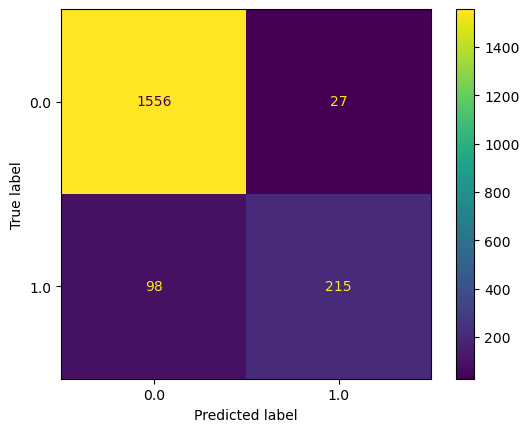

In [80]:

print('Grid search found best gamma:', svm_model.best_estimator_.get_params()['svm__gamma'])
print('Grid search found best penalty:', svm_model.best_estimator_.get_params()['svm__kernel'])
print('Grid search found best hyperparameter C:', svm_model.best_estimator_.get_params()['svm__C'])
print("The following is only important if using poly or sigmoid kernel:")
print('Grid search found best coef0:', svm_model.best_estimator_.get_params()['svm__coef0'])


analyze_model(svm_model, X_test, X_train, y_test, y_train)